In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='./dataset', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./dataset', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)


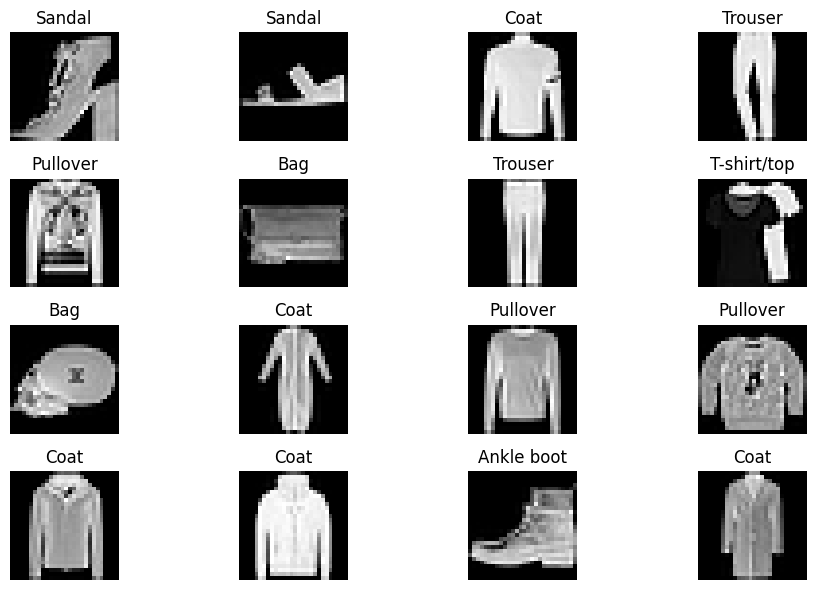

In [3]:
# Class labels for FashionMNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
# Get one batch of images
images, labels = next(iter(train_loader))

# Plot the images
plt.figure(figsize=(10, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
class FashionClassifierConv(nn.Module):
    def __init__(self):
        super(FashionClassifierConv, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                  # 28x28 → 784
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)             # 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FashionClassifierConv().to(device)

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10 — Loss: 0.8307 — Test Accuracy: 81.24%
Epoch 2/10 — Loss: 0.4497 — Test Accuracy: 84.72%
Epoch 3/10 — Loss: 0.3890 — Test Accuracy: 86.34%
Epoch 4/10 — Loss: 0.3533 — Test Accuracy: 87.08%
Epoch 5/10 — Loss: 0.3292 — Test Accuracy: 87.53%
Epoch 6/10 — Loss: 0.3096 — Test Accuracy: 88.61%
Epoch 7/10 — Loss: 0.2966 — Test Accuracy: 88.47%
Epoch 8/10 — Loss: 0.2828 — Test Accuracy: 88.34%
Epoch 9/10 — Loss: 0.2728 — Test Accuracy: 89.00%
Epoch 10/10 — Loss: 0.2612 — Test Accuracy: 89.09%
Training took 107.66 seconds


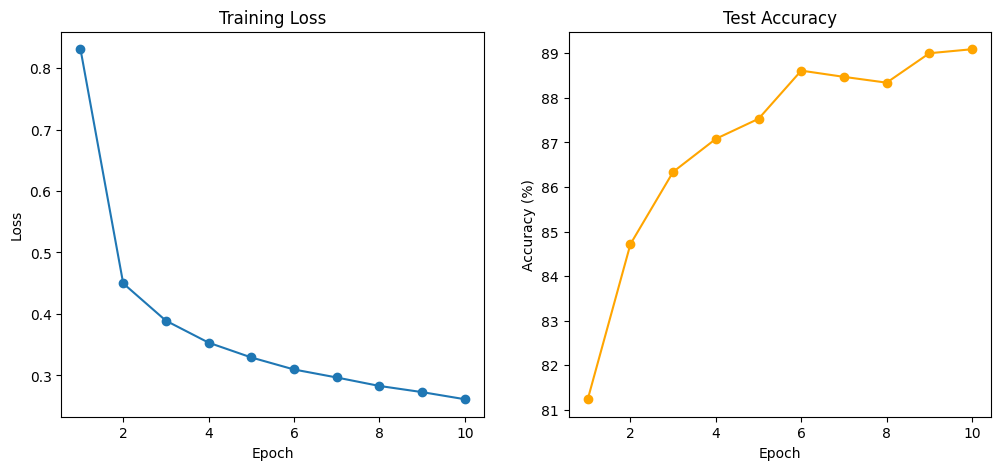

In [7]:
import matplotlib.pyplot as plt
import time

num_epochs = 10
train_losses = []
test_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f} — Test Accuracy: {accuracy*100:.2f}%")

end_time = time.time()
print(f"Training took {(end_time - start_time):.2f} seconds")

# Plot loss and accuracy
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies], marker='o', color='orange')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()
